<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil, os
# shutil.rmtree("game_logs")
shutil.unpack_archive('game_logs.zip', './')
shutil.unpack_archive('validation.zip', './')
print(len(os.listdir('game_logs')))
print(len(os.listdir('validation')))
train_filenames = os.listdir('game_logs')
val_filenames = os.listdir('validation')
train_filenames.sort()
val_filenames.sort()
print(train_filenames[0], val_filenames[0])

28004
19122
316756.npz 316756.npz


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [3]:
# Constants
T = 1 # Number of Timesteps for which boards are present in input
N = 8 # board size
HIDDEN_LAYER = 1 # hidden layer will be N * N * HIDDEN_LAYER neurons long
OUTPUT_LAYER = 73 # output layer will be N * N * OUTPUT_LAYER neurons long
BLOCKS = 10
FILTERS = 128

In [4]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size, randomize) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = randomize
    self.boards_per_game = 4
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join('game_logs',f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if self.randomize:
        index = np.random.choice(length, min(self.boards_per_game, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
    
    Y_new = []
    for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return np.array(inputs), np.array(Y_new)

In [5]:
batch_size = 32

training_generator = My_Custom_Generator(train_filenames, batch_size, True)
validation_generator = My_Custom_Generator(val_filenames, batch_size, False)

In [6]:
inputs = tf.keras.Input(shape=(8, 8, 14))
x1 = tf.keras.layers.LeakyReLU()(inputs)

x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(14, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)

added = tf.keras.layers.add([x1, x])
x = tf.keras.layers.LeakyReLU()(added)

x = tf.keras.layers.Conv2D(73, (3,3),activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, x)
model.summary()
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 14)]   0           []                               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8, 8, 14)     0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 128)    16256       ['leaky_re_lu[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 128)   512         ['conv2d[0][0]']                 
 alization)                                                                                   

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [8]:
history = model.fit_generator(generator=training_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 20,
                   verbose = 1,
                   validation_data = validation_generator,
                   validation_steps = int(1000 // batch_size)) # Use only 1000 samples for validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
875/875 [==============================] - 152s 161ms/step - loss: 4.0378 - categorical_accuracy: 0.2324 - val_loss: 4.1963 - val_categorical_accuracy: 0.1497
Epoch 2/20
875/875 [==============================] - 140s 160ms/step - loss: 3.2371 - categorical_accuracy: 0.2746 - val_loss: 3.8087 - val_categorical_accuracy: 0.1597
Epoch 3/20
875/875 [==============================] - 140s 160ms/step - loss: 3.0409 - categorical_accuracy: 0.2900 - val_loss: 3.6238 - val_categorical_accuracy: 0.1804
Epoch 4/20
875/875 [==============================] - 149s 170ms/step - loss: 2.9470 - categorical_accuracy: 0.3007 - val_loss: 3.5341 - val_categorical_accuracy: 0.1808
Epoch 5/20
875/875 [==============================] - 144s 164ms/step - loss: 2.9047 - categorical_accuracy: 0.3036 - val_loss: 3.5433 - val_categorical_accuracy: 0.1835
Epoch 6/20
875/875 [==============================] - 143s 163ms/step - loss: 2.8668 - categorical_accuracy: 0.3071 - val_loss: 3.4610 - val_categoric

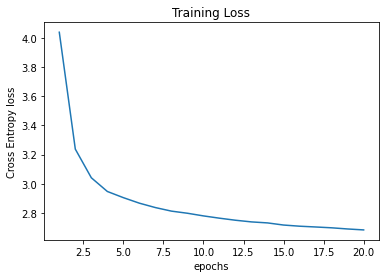

In [9]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

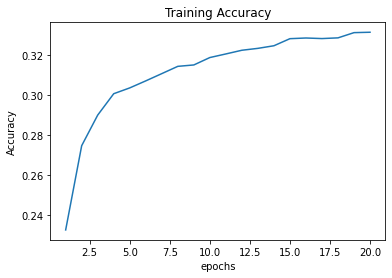

In [12]:
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['categorical_accuracy'])))),  history.history['categorical_accuracy'])

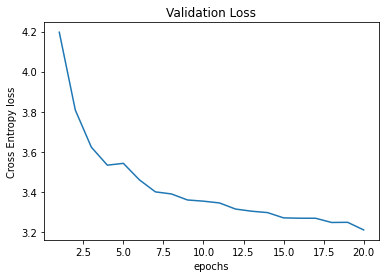

In [10]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

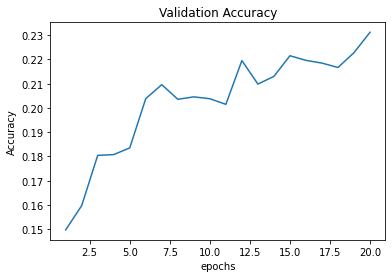

In [13]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_categorical_accuracy'])))),  history.history['val_categorical_accuracy'])

In [11]:
print(history.history)

{'loss': [4.037755966186523, 3.2370738983154297, 3.0408730506896973, 2.9469857215881348, 2.9046947956085205, 2.866838216781616, 2.8367183208465576, 2.812448024749756, 2.7978572845458984, 2.7796881198883057, 2.764037609100342, 2.749990463256836, 2.7385730743408203, 2.7316861152648926, 2.7170965671539307, 2.7091827392578125, 2.703817367553711, 2.698148012161255, 2.6901791095733643, 2.683699607849121], 'categorical_accuracy': [0.23240089416503906, 0.27462172508239746, 0.28995439410209656, 0.300668865442276, 0.303579717874527, 0.3071022927761078, 0.31073465943336487, 0.31438177824020386, 0.31508156657218933, 0.31879568099975586, 0.3205980062484741, 0.32245224714279175, 0.3234000504016876, 0.3247057795524597, 0.3282530903816223, 0.3285893499851227, 0.3283076286315918, 0.328659325838089, 0.3312794864177704, 0.3314763605594635], 'val_loss': [4.196321964263916, 3.808664560317993, 3.6238322257995605, 3.5341339111328125, 3.5432732105255127, 3.4610488414764404, 3.401136636734009, 3.39080643653869